### HyperSETI (larawag)

Name TBD. Larawag, the "signal watcher", is the Australian Wardaman people's name for Epsilon Scorpii (recently adopted by the IAU). 

In [1]:
%matplotlib inline

In [2]:
from hyperseti import logger, dedoppler, run_pipeline, apply_boxcar, normalize, merge_hits, hitsearch

import cupy as cp
import logging
from astropy import units as u
import setigen as stg
import pylab as plt
import pandas as pd
import numpy as np

blosc filter already loaded, skip it.


### Basic tests with setigen

Inserted drift rate:  0.0 Hz / s 	SUM: 2038.14
Recovered drift rate: -0.03125 Hz / s 	SUM: 2038.14

Inserted drift rate:  0.1 Hz / s 	SUM: 1676.79
Recovered drift rate: 0.125 Hz / s 	SUM: 1611.14

Inserted drift rate:  0.5 Hz / s 	SUM: 1533.37
Recovered drift rate: 0.5 Hz / s 	SUM: 1530.74

Inserted drift rate:  -0.25 Hz / s 	SUM: 1619.79
Recovered drift rate: -0.28125 Hz / s 	SUM: 1460.95

Inserted drift rate:  -0.5 Hz / s 	SUM: 1535.31
Recovered drift rate: -0.5 Hz / s 	SUM: 1532.39



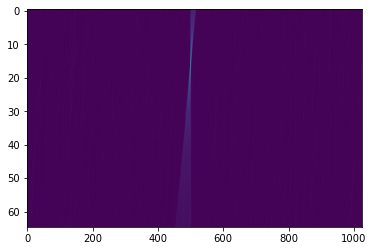

In [23]:
def test_dedoppler():
    """ Basic tests of the dedoppler functionality """
    
    # zero drift test, no normalization
    test_data = np.ones(shape=(32, 1024))
    test_data[:, 511] = 10
    
    metadata = {'fch1': 1000*u.MHz, 
            'dt': 1.0*u.s, 
            'df': 1.0*u.Hz}
    
    dedopp, metadata = dedoppler(test_data, metadata, boxcar_size=1,
                                 max_dd=1.0, apply_normalization=False)
    
    assert np.max(dedopp) == np.sum(test_data[:, 511])
    

    
    for dr_test in (0.0, 0.1, 0.5, -0.25, -0.5):
        # single drifting tone
        frame = stg.Frame(fchans=2**10*u.pixel, tchans=32*u.pixel,
                  df=metadata['df'], dt=metadata['dt'], fch1=metadata['fch1'])
    
        tone = {'f_start': frame.get_frequency(index=500), 'drift_rate': dr_test * u.Hz / u.s, 'snr': 500, 'width': metadata['df']}
        noise = frame.add_noise(x_mean=1, noise_type='chi2')

        signal = frame.add_signal(stg.constant_path(f_start=tone['f_start'],
                                                    drift_rate=tone['drift_rate']),
                                  stg.constant_t_profile(level=frame.get_intensity(snr=tone['snr'])),
                                  stg.gaussian_f_profile(width=tone['width']),
                                  stg.constant_bp_profile(level=1))

        dedopp, metadata = dedoppler(frame.data, metadata, boxcar_size=1,
                                     max_dd=1.0, apply_normalization=False)

        # Manual dedoppler search -- just find max channel (only works if S/N is good)
        manual_dd_tot = 0
        for ii in range(frame.data.shape[0]):
            manual_dd_tot += np.max(frame.data[ii])
        plt.imshow(dedopp, aspect='auto')

        maxpixel = np.argmax(dedopp)
        mdrift, mchan = (maxpixel // 1024, maxpixel % 1024)
        optimal_drift = metadata['drift_trials'][mdrift]
        maxpixel_val = np.max(dedopp)
        
        frac_recovered = (maxpixel_val / manual_dd_tot)
        
        print(f"Inserted drift rate:  {tone['drift_rate']} \tSUM: {manual_dd_tot:2.2f}")
        print(f"Recovered drift rate: {optimal_drift} Hz / s \tSUM: {maxpixel_val:2.2f}\n")
        
        # Channel should detected at +/- 1 chan
        assert np.abs(mchan - 500) <= 1
        
        # Drift rate should be detected +/- 1 drift resolution
        assert np.abs(optimal_drift - dr_test) <= 1.01*metadata['dd'].value

        # Recovered signal sum should be close to manual method
        assert 1.001 >= frac_recovered >= 0.825

test_dedoppler()

## Dedoppler efficiency (basic)

For some drift rates a tone will end up in more than one bin for a given timestep, even for slowly drifting signals. This causes a loss of S/N. 

| Rows | Min. (%) | Max. (%) | Mean (%) | Median (%) | STD (%) |
| --- | --- | --- | ---| ---| ---| 
| 4   | 100.00    | 100.00   | 100.00   | 100.00 |  0.00 |
|8  | 75.00 | 100.00  | 93.75 | 100.00| 11.57 |
|32 | 68.75 |  100.00 | 85.16 | 81.25 | 11.20 |
|64 | 68.75 |  100.00 | 81.64 | 78.12 | 9.83|
|128 |64.06 |  100.00 | 77.93 | 75.00 | 8.88|
|256 |64.06 |  100.00 | 75.17 | 73.44 | 7.68|
|512 |60.16 |  100.00 | 72.42 | 71.09 | 6.84|
|1024 | 60.16 |100.00 | 70.08 | 69.14 | 6.10|
|2048 | 56.84 |100.00 | 67.92 | 66.60 | 5.53|
|4096 | 56.84 |100.00 | 66.01 | 64.94 | 5.06|


Let's see how hyperseti deals with it.

16491.68


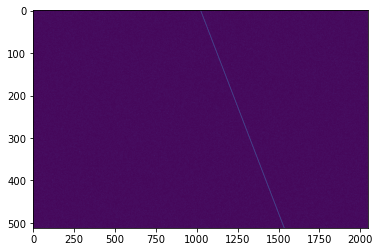

In [134]:
n_timesteps=512
n_chan=2048
n_trials=1001 
max_drift=1.0
dr_test = 1.0

frame = stg.Frame(fchans=n_chan*u.pixel, tchans=n_timesteps*u.pixel,
          df=metadata['df'], dt=metadata['dt'], fch1=metadata['fch1'])

tone = {'f_start': frame.get_frequency(index=n_chan//2), 'drift_rate': dr_test * u.Hz / u.s, 'snr': 1000, 'width': metadata['df']}
noise = frame.add_noise(x_mean=1, noise_type='chi2')

signal = frame.add_signal(stg.constant_path(f_start=tone['f_start'],
                                            drift_rate=tone['drift_rate']),
                          stg.constant_t_profile(level=frame.get_intensity(snr=tone['snr'])),
                          stg.gaussian_f_profile(width=tone['width']),
                          stg.constant_bp_profile(level=1))

dedopp, metadata = dedoppler(frame.data, metadata, boxcar_size=1,
                             max_dd=max_drift, apply_normalization=False)
plt.imshow(frame.data, aspect='auto')

print(np.max(dedopp))

Efficiencies: MAX MIN MEAN MEDIAN STD
4 1.000 0.811 0.963 1.000 0.056
16 1.000 0.814 0.917 0.911 0.050
32 1.000 0.841 0.909 0.905 0.039
64 1.000 0.835 0.903 0.895 0.036
128 1.000 0.861 0.901 0.895 0.028
256 1.000 0.876 0.904 0.898 0.025
512 1.000 0.878 0.903 0.900 0.024


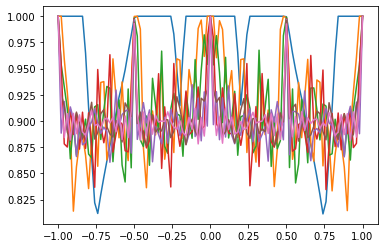

In [150]:
def test_dedoppler_recovery(n_timesteps=32, n_chan=2048, n_trials=1001, max_drift=1.0, boxcar_size=1):
    """ Basic tests of the dedoppler functionality """
    metadata = {'fch1': 1000*u.MHz, 'dt': 1.0*u.s, 'df': 1.0*u.Hz}
    
    test_drift_rates = np.linspace(-max_drift, max_drift, n_trials)
    frac_recovered_arr = []
    for dr_test in test_drift_rates:
        # single drifting tone
        frame = stg.Frame(fchans=n_chan*u.pixel, tchans=n_timesteps*u.pixel,
                  df=metadata['df'], dt=metadata['dt'], fch1=metadata['fch1'])
    
        tone = {'f_start': frame.get_frequency(index=n_chan//2), 
                'drift_rate': dr_test * u.Hz / u.s, 
                'snr': 1000, 
                'width': metadata['df']}
        
        noise = frame.add_noise(x_mean=1, noise_type='chi2')

        signal = frame.add_signal(stg.constant_path(f_start=tone['f_start'],
                                                    drift_rate=tone['drift_rate']),
                                  stg.constant_t_profile(level=frame.get_intensity(snr=tone['snr'])),
                                  stg.gaussian_f_profile(width=tone['width']),
                                  stg.constant_bp_profile(level=1))

        dedopp, metadata = dedoppler(frame.data, metadata, boxcar_size=boxcar_size,
                                     max_dd=max_drift, apply_normalization=False)

        # Manual dedoppler search -- just find max channel (only works if S/N is good)
        manual_dd_tot = 0
        for ii in range(frame.data.shape[0]):
            manual_dd_tot += np.max(frame.data[ii])

        maxpixel = np.argmax(dedopp)
        mdrift, mchan = (maxpixel // n_chan, maxpixel % n_chan)
        optimal_drift = metadata['drift_trials'][mdrift]
        maxpixel_val = np.max(dedopp)
        
        frac_recovered = (maxpixel_val / manual_dd_tot)
        
        frac_recovered_arr.append(frac_recovered)
        
    plt.plot(test_drift_rates, frac_recovered_arr, label=n_timesteps) 
    return test_drift_rates, frac_recovered_arr

t = {}
for nstep in (4, 16, 32, 64, 128, 256, 512):
    t[nstep]   = test_dedoppler_recovery(n_timesteps=nstep, n_chan=2048, n_trials=101, max_drift=1.0)
    

print("Efficiencies: MAX MIN MEAN MEDIAN STD")
for nc, (trial, eff) in t.items():
    print(f"{nc} {np.max(eff):2.3f} {np.min(eff):2.3f} {np.mean(eff):2.3f} {np.median(eff):2.3f} {np.std(eff):2.3f}")


(60.0, 70.0)

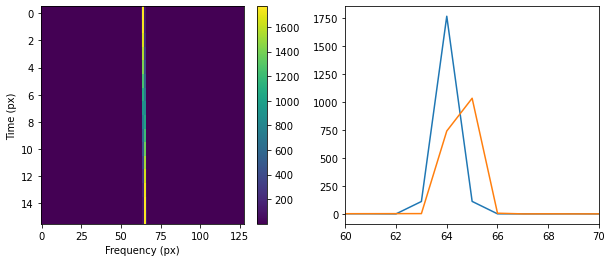

In [173]:
n_timesteps = 16
n_chan = 128
dr_test = 0.07

frame = stg.Frame(fchans=n_chan*u.pixel, tchans=n_timesteps*u.pixel,
          df=metadata['df'], dt=metadata['dt'], fch1=metadata['fch1'])

tone = {'f_start': frame.get_frequency(index=n_chan//2), 
        'drift_rate': dr_test * u.Hz / u.s, 
        'snr': 10000, 
        'width': metadata['df']}

noise = frame.add_noise(x_mean=1, noise_type='chi2')

signal = frame.add_signal(stg.constant_path(f_start=tone['f_start'],
                                            drift_rate=tone['drift_rate']),
                          stg.constant_t_profile(level=frame.get_intensity(snr=tone['snr'])),
                          stg.gaussian_f_profile(width=tone['width']),
                          stg.constant_bp_profile(level=1))

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
frame.render()

plt.subplot(1,2,2)
plt.plot(frame.data[0])
plt.plot(frame.data[8])
plt.xlim(60, 70)


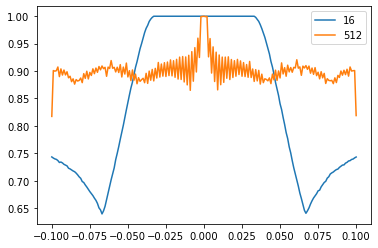

In [151]:
t = {}
for nstep in (16, 512,):
    t[nstep]   = test_dedoppler_recovery(n_timesteps=nstep, n_chan=1024, n_trials=201, max_drift=0.1)

plt.legend()

## Dedoppler smearing

One of the major issues with current `turboseti` is doppler smearing across channels at large drift rates. 

For example, if channels are 1 Hz wide, 1s integration, and drift rate is 2 Hz/s, the signal power will be divided between two channels. More generally, you get a decrease in power of `N` per channel, where `N = driftrate / chanwidth * int_time`.

One can sum across channels to retrieve the power, but the amount of noise is larger in two channels than in one channel -- so you get a `sqrt(N)` decrease is S/N due to smearing.



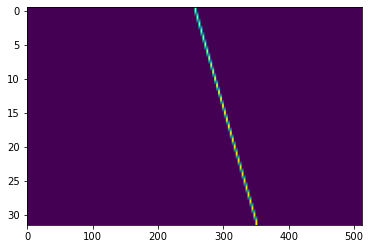

In [109]:
def generate_drifting_tone(n_chan, n_timesteps, n_drift_per_step, sigval=10):
    """ Simple tone generator to generate smeared tones """
    bg = np.zeros((n_timesteps, n_chan))
    
    for ii in range(0, bg.shape[0]):
        for nd in range(n_drift_per_step):
            z = n_drift_per_step * ii + nd
            bg[ii, bg.shape[1]//2 + z] = sigval / n_drift_per_step
    return bg

def maxhold_dedoppler(data):
    """ A simple and crappy dedoppler algorithm 
    
    Finds the top value in each timestep and adds together.
    This method only works for single channel tones with high SNR
    """
    manual_dd_tot = 0
    for ii in range(bg.shape[0]):
        manual_dd_tot += np.max(bg[ii])
    return manual_dd_tot

dtest = generate_drifting_tone(512, 32, 3)
plt.imshow(dtest, aspect='auto')

Generate a drifting tone that will be power split across two channels. Use MAXHOLD algorithm and compare against `hyperseti` dedopp

Total power in frame: 320.0
MAXHOLD recovered power: 160.0
dedopp recovered power (boxcar 1): 160.0
dedopp recovered power (boxcar 2): 320.0


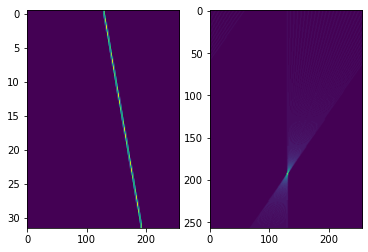

In [115]:
# Drift rate of 2 channels / integration
# To simulate channel smearing
metadata = {'fch1': 1000*u.MHz, 'dt': 1.0*u.s, 'df': 1.0*u.Hz}

bg = generate_drifting_tone(n_chan=256, n_timesteps=32, n_drift_per_step=2, sigval=10)
print(f"Total power in frame: {np.sum(bg)}")
      
plt.subplot(1,2,1)
plt.imshow(bg, aspect='auto')

# Compute dedoppler using basic maxhold method
maxhold_res = maxhold_dedoppler(bg)
print(f"MAXHOLD recovered power: {maxhold_res}")

# With boxcar_size = 1 we should recover 160
dedopp, metadata = dedoppler(bg, metadata, boxcar_size=1, 
                             max_dd=2.0, apply_normalization=False)

maxpixel = np.argmax(dedopp)
mdrift, mchan = (maxpixel // 1024, maxpixel % 1024)
maxpixel_val = np.max(dedopp)
print(f"dedopp recovered power (boxcar 1): {maxpixel_val}")
assert maxpixel_val == maxhold_res

# With boxcar_size = 2 we should recover 320 (full amount)
metadata = {'fch1': 1000*u.MHz, 'dt': 1.0*u.s, 'df': 1.0*u.Hz}
dedopp, metadata = dedoppler(bg, metadata, boxcar_size=2, 
                             max_dd=4.0, apply_normalization=False)

maxpixel = np.argmax(dedopp)
mdrift, mchan = (maxpixel // 1024, maxpixel % 1024)
maxpixel_val = np.max(dedopp)
print(f"dedopp recovered power (boxcar 2): {maxpixel_val}")
assert maxpixel_val == np.sum(bg)

plt.subplot(1,2,2)
plt.imshow(dedopp,aspect='auto')

### Dedoppler efficiency with smearing

Efficiencies: MAX MIN MEAN MEDIAN
4 1.000 0.816  0.964, 1.000
16 1.000 0.835  0.922, 0.911
32 1.000 0.850  0.912, 0.902
64 1.000 0.842  0.908, 0.902
128 1.000 0.851  0.893, 0.888


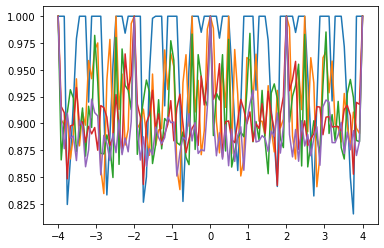

In [118]:
def test_dedoppler_recovery_smearing(n_timesteps=32, n_chan=2048, n_trials=1001, max_drift=1.0, snr=1000):
    """ Basic tests of the dedoppler functionality """
    metadata = {'fch1': 1000*u.MHz, 'dt': 1.0*u.s, 'df': 1.0*u.Hz}
    
    test_drift_rates = np.linspace(-max_drift, max_drift, n_trials)
    frac_recovered_arr = []
    for dr_test in test_drift_rates:
        # single drifting tone
        frame = stg.Frame(fchans=n_chan*u.pixel, tchans=n_timesteps*u.pixel,
                  df=metadata['df'], dt=metadata['dt'], fch1=metadata['fch1'])
    
        tone = {'f_start': frame.get_frequency(index=n_chan//2), 'drift_rate': dr_test * u.Hz / u.s, 
                                               'snr': snr, 'width': metadata['df']}
        noise = frame.add_noise(x_mean=0, x_std=1.0, noise_type='gaussian')
        
        dedopp, metadata = dedoppler(frame.data, metadata, boxcar_size=1,
                                     max_dd=max_drift, apply_normalization=False)

        maxpixel = np.argmax(dedopp)
        mdrift, mchan = (maxpixel // 1024, maxpixel % 1024)
        optimal_drift = metadata['drift_trials'][mdrift]
        maxpixel_val = np.max(dedopp)
        
        frac_recovered = (maxpixel_val / snr)
        
        frac_recovered_arr.append(frac_recovered)
        
    plt.plot(test_drift_rates, frac_recovered_arr)
        
    return test_drift_rates, frac_recovered_arr

t = {}
t[4]   = test_dedoppler_recovery(n_timesteps=4, n_chan=1024, n_trials=101, max_drift=4.0)
t[16]  = test_dedoppler_recovery(n_timesteps=16, n_chan=1024, n_trials=101, max_drift=4.0)
t[32]  = test_dedoppler_recovery(n_timesteps=32, n_chan=1024, n_trials=101, max_drift=4.0)
t[64]  = test_dedoppler_recovery(n_timesteps=64, n_chan=1024, n_trials=101, max_drift=4.0)
t[128] = test_dedoppler_recovery(n_timesteps=128, n_chan=1024, n_trials=101, max_drift=4.0)

print("Efficiencies: MAX MIN MEAN MEDIAN")
for nc, (trial, eff) in t.items():
    print(f"{nc} {np.max(eff):2.3f} {np.min(eff):2.3f}  {np.mean(eff):2.3f}, {np.median(eff):2.3f}")

### Test merge_hits

In [12]:
%matplotlib inline

In [35]:
n_timesteps=64 
n_chan=4096
signal_bw = 16

metadata = {'fch1': 1000*u.MHz, 'dt': 1.0*u.s, 'df': 1.0*u.Hz}

frame = stg.Frame(fchans=n_chan*u.pixel, tchans=n_timesteps*u.pixel,
          df=metadata['df'], dt=metadata['dt'], fch1=metadata['fch1'])

d = frame.add_noise(x_mean=0, x_std=1, noise_type='gaussian')

for ii in range(signal_bw):
    d[:, n_chan // 2 + ii]   = 1000.0 / signal_bw

,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
0,-0.015625,1000.002056,64000.0,63,2056,16


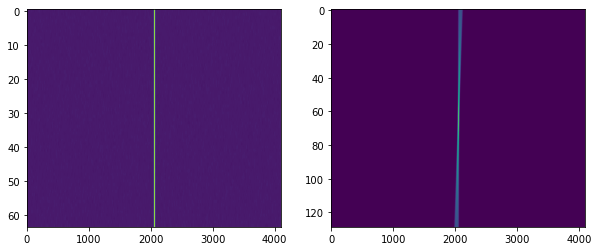

In [36]:
dedopp, metadata = dedoppler(d, metadata, boxcar_size=16, max_dd=1.0, apply_normalization=False)

hits = hitsearch(dedopp, metadata, min_distance=30, threshold=1000).sort_values('snr')

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.imshow(d, aspect='auto')

plt.subplot(1,2,2)
plt.imshow(dedopp, aspect='auto')

hits

In [46]:
print(dedopp.shape)

(129, 4096)


In [37]:
dedopp, metadata, hits = run_pipeline(d, metadata, max_dd=1.0, min_dd=None, threshold=100, 
                                          min_distance=30, n_boxcar=7, merge_boxcar_trials=False)

for rid, hit in hits.iterrows():
     assert(np.abs(hit['channel_idx'] - 2048) < np.max((signal_bw, hit['boxcar_size'])))
hits

,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
0,-0.250000,1000.002063,500.000000,48,2063,1
1,0.218750,1000.002048,500.000000,78,2048,1
2,-0.234375,1000.002063,707.106812,49,2063,2
3,0.234375,1000.002049,707.106812,79,2049,2
4,-0.203125,1000.002062,1000.000000,51,2062,4
5,-0.140625,1000.002060,1414.213623,55,2060,8
6,-0.015625,1000.002056,2000.000000,63,2056,16
7,0.140625,1000.002048,1415.502930,73,2048,32
8,0.031250,1000.002038,1001.729431,66,2038,64


In [38]:
merged_hits = merge_hits(hits)
assert len(merged_hits) == 1
merged_hits

,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
6,-0.015625,1000.002056,2000.0,63.0,2056.0,16.0


In [45]:
dedopp, metadata, hits2 = run_pipeline(d, metadata, max_dd=1.0, min_dd=None, threshold=100, 
                                          min_distance=20, n_boxcar=5, merge_boxcar_trials=True)
#assert len(hits2) == len(merged_hits) == 1
hits2

,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
7,-0.015625,1000.002056,2000.0,63.0,2056.0,16.0


### Prominent peaks

In [49]:
from cupyimg.skimage.feature.peak import _prominent_peaks as prominent_peaks

In [63]:
intensity, xcoords, ycoords = prominent_peaks(cp.asarray(dedopp), min_xdistance=100, min_ydistance=dedopp.shape[1]//8, threshold=100)
ycoords

array([ 64,   0,   0, 109,  21,  76, 112,  21,  75,  51])

In [74]:
import time
def hitsearch_pp(dedopp, metadata, threshold=10, min_xdistance=None, min_ydistance=None):
    """ Search for hits using _prominent_peaks method in cupyimg.skimage
    
    Args:
        dedopp (np.array): Dedoppler search array of shape (N_trial, N_chan)
        drift_trials (np.array): List of dedoppler trials corresponding to dedopp N_trial axis
        metadata (dict): Dictionary of metadata needed to convert from indexes to frequencies etc
        threshold (float): Threshold value (absolute) above which a peak can be considered
        min_distance (int): Minimum distance in pixels to nearest peak
    
    Returns:
        results (pd.DataFrame): Pandas dataframe of results, with columns 
                                    driftrate: Drift rate in hz/s
                                    f_start: Start frequency channel
                                    snr: signal to noise ratio
                                    driftrate_idx: Index in driftrate array
                                    channel_idx: Index in frequency array
    """
    
    drift_trials = metadata['drift_trials']
    
    if min_xdistance is None:
        min_xdistance = metadata['boxcar_size'] * 2
    
    if min_ydistance is None:
        min_ydistance = len(drift_trials) // 4
    
    # Unfortunately we need a CPU copy of the dedoppler for peak finding
    # This means lots of copying back and forth, so potential bottleneck
    if isinstance(dedopp, np.ndarray):
        dedopp_cpu = dedopp
    else:
        dedopp_cpu = cp.asnumpy(dedopp)
        
    # Copy over to GPU if required
    dedopp_gpu = cp.asarray(dedopp.astype('float32'))
    
    t0 = time.time()
    intensity, xcoords, ycoords = prominent_peaks(dedopp_gpu, min_xdistance=min_xdistance, min_ydistance=min_ydistance, threshold=threshold)
    # copy results over to CPU space
    intensity, xcoords, ycoords = cp.asnumpy(intensity), cp.asnumpy(xcoords), cp.asnumpy(ycoords)
    t1 = time.time()
    logger.info(f"Peak find time: {(t1-t0)*1e3:2.2f}ms")
    
    
    driftrate_peaks = drift_trials[ycoords]
    frequency_peaks = metadata['fch1'] + metadata['df'] * xcoords
    

    results = {
        'driftrate': driftrate_peaks,
        'f_start': frequency_peaks,
        'snr': intensity,
        'driftrate_idx': ycoords,
        'channel_idx': xcoords
    }
    
    # Append numerical metadata keys
    for key, val in metadata.items():
        if isinstance(val, (int, float)):
            results[key] = val
    
    return pd.DataFrame(results)

hitsearch_pp(dedopp, metadata, threshold=100).sort_values('snr')

,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
12,-0.203125,1000.003794,100.182449,51,3794,16
11,0.578125,1000.000510,100.500732,101,510,16
10,0.968750,1000.001912,102.178734,126,1912,16
9,0.171875,1000.000437,102.195671,75,437,16
8,-0.671875,1000.002346,102.957428,21,2346,16
7,0.750000,1000.003651,105.392891,112,3651,16
6,0.187500,1000.004079,113.521469,76,4079,16
5,0.765625,1000.002984,117.960274,113,2984,16
4,-0.671875,1000.003004,118.680870,21,3004,16
3,0.703125,1000.003187,120.577499,109,3187,16
